In [29]:
!pip install rdflib pandas tqdm matplotlib pyviz

   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ------------- -------------------------- 262.1/756.0 kB ? eta -:--:--
   --------------------------- ------------ 524.3/756.0 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 756.0/756.0 kB 2.1 MB/s  0:00:00

   ---------------------------------------- 0/2 [jsonpickle]
   -------------------- ------------------- 1/2 [pyvis]
   ---------------------------------------- 2/2 [pyvis]



# Task 2.1 
Convert the Recipes, Restaurants, and Nutrition datasets into RDF triples. Assign unique URIs using the base namespace http://kg-course.io/food-nutrition/ and add rdf:type statements to all entities using the schema from Task 1.

In [17]:
import pandas as pd
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD, SDO
from tqdm import tqdm
import re

In [ ]:
# Hint 1: Read the first 10000 rows of each dataset only to manage computational complexity and avoid scalability issues
recipes_df = pd.read_csv("data/cleaned_recipes.csv", nrows=10000)
restaurants_df = pd.read_csv("data/cleaned_restaurants.csv", nrows=10000)
nutrition_df = pd.read_csv("data/cleaned_nutrition.csv", nrows=10000)

In [19]:
# Define namespaces
BASE = Namespace("http://kg-course.io/food-nutrition/")
KGS = Namespace("http://kg-course.io/food-nutrition/schema/")

g = Graph()
g.bind("base", BASE)
g.bind("kgs", KGS)

g.parse("vocabulary.ttl", format="ttl") # parse the schema vocabulary

# Helper function to create unique URIs
def make_uri(entity_type, identifier):
    safe_id = re.sub(r'\W+', '_', str(identifier))
    return URIRef(BASE[f"{entity_type}/{safe_id}"])

In [20]:
# Convert recipes to RDF
for _, row in tqdm(recipes_df.iterrows(), total=len(recipes_df)):
    
    recipe_uri = make_uri("recipe", row["RecipeId"])
    
    # rdf:type
    g.add((recipe_uri, RDF.type, SDO.Recipe))
    
    # Name
    if pd.notna(row["Name"]):
        g.add((recipe_uri, SDO.name, Literal(row["Name"], datatype=XSD.string)))

    # Category (Cuisine equivalent)
    if pd.notna(row["RecipeCategory"]):
        g.add((recipe_uri, SDO.recipeCategory, Literal(row["RecipeCategory"], datatype=XSD.string)))
    
    # CookTime
    if pd.notna(row["CookTime"]):
        g.add((recipe_uri, SDO.cookTime, Literal(float(row["CookTime"]), datatype=XSD.decimal)))
    
    # PrepTime
    if pd.notna(row["PrepTime"]):
        g.add((recipe_uri, SDO.prepTime, Literal(float(row["PrepTime"]), datatype=XSD.decimal)))
    
    # Keywords
    if pd.notna(row["Keywords"]):
        g.add((recipe_uri, SDO.keywords, Literal(row["Keywords"], datatype=XSD.string)))

    # Ingredients
    if pd.notna(row["RecipeIngredientParts"]):
        g.add((recipe_uri, SDO.recipeIngredient, Literal(row["RecipeIngredientParts"], datatype=XSD.string)))

    # Instructions
    if pd.notna(row["RecipeInstructions"]):
        g.add((recipe_uri, SDO.recipeInstructions, Literal(row["RecipeInstructions"], datatype=XSD.string)))

    if pd.notna(row["DatePublished"]):
        g.add((recipe_uri, SDO.datePublished, Literal(row["DatePublished"], datatype=XSD.date)))
        
    if pd.notna(row["Images"]):
        for image in row["Images"].split(', '):
            if image != '' or image is not None:
                g.add((recipe_uri, SDO.image, Literal(f"{image}", datatype=XSD.anyURI)))

100%|██████████| 100/100 [00:00<00:00, 4530.71it/s]


In [21]:
# Convert restaurants to RDF
for _, row in tqdm(restaurants_df.iterrows(), total=len(restaurants_df)):
    
    restaurant_uri = make_uri("restaurant", row["Restaurant ID"])

    # rdf:type
    g.add((restaurant_uri, RDF.type, SDO.Restaurant))
    
    # Name
    if pd.notna(row["Restaurant Name"]):
        g.add((restaurant_uri, SDO.name, Literal(row["Restaurant Name"], datatype=XSD.string)))
    
    # Cuisine
    if pd.notna(row["Cuisines"]):
        g.add((restaurant_uri, SDO.servesCuisine, Literal(row["Cuisines"], datatype=XSD.string)))

    # Locality
    if pd.notna(row["Locality Verbose"]):
        g.add((restaurant_uri, SDO.addressLocality, Literal(row["Locality Verbose"], datatype=XSD.string)))

    # Currency
    if pd.notna(row["Currency"]):
        g.add((restaurant_uri, SDO.currenciesAccepted, Literal(row["Currency"], datatype=XSD.string)))

    # hasOnlineDelivery
    if pd.notna(row["Has Online delivery"]):
        g.add((restaurant_uri, KGS.hasOnlineDelivery, Literal(bool(row["Has Online delivery"]), datatype=XSD.boolean)))

    # AverageCostOfTwo
    if pd.notna(row["Average cost of two in USD"]):
        g.add((restaurant_uri, KGS.averageCostOfTwo, Literal(float(row["Average cost of two in USD"]), datatype=XSD.decimal)))

    # Rating
    if pd.notna(row["Aggregate rating"]):
        g.add((restaurant_uri, SDO.starRating, Literal(float(row["Aggregate rating"]), datatype=XSD.decimal)))

100%|██████████| 100/100 [00:00<00:00, 5539.30it/s]


In [22]:
for i , row in tqdm(nutrition_df.iterrows(), total=len(nutrition_df)):
    nutrition_uri = make_uri("nutrition", i)
    g.add((nutrition_uri, RDF.type, SDO.NutritionInformation))
    g.add((nutrition_uri, SDO.calories, Literal(row["Calories"], datatype=XSD.decimal)))
    g.add((nutrition_uri, SDO.fatContent, Literal(row["FatContent"], datatype=XSD.decimal)))
    g.add((nutrition_uri, SDO.saturatedFatContent, Literal(row["SaturatedFatContent"], datatype=XSD.decimal)))
    g.add((nutrition_uri, SDO.cholesterolContent, Literal(row["CholesterolContent"], datatype=XSD.decimal)))
    g.add((nutrition_uri, SDO.sodiumContent, Literal(row["SodiumContent"], datatype=XSD.decimal)))
    g.add((nutrition_uri, SDO.carbohydrateContent, Literal(row["CarbohydrateContent"], datatype=XSD.decimal)))
    g.add((nutrition_uri, SDO.fiberContent, Literal(row["FiberContent"], datatype=XSD.decimal)))
    g.add((nutrition_uri, SDO.sugarContent, Literal(row["SugarContent"], datatype=XSD.decimal)))
    g.add((nutrition_uri, SDO.proteinContent, Literal(row["ProteinContent"], datatype=XSD.decimal)))

    # Link Nutrition → Recipe
    recipe_ids = recipes_df[recipes_df['Name'] == row['Name']]['RecipeId'].values
    for recipe_id in recipe_ids:
        recipe_uri = make_uri("recipe", recipe_id)
        # print(nutrition_uri, recipe_id, recipe_uri)
        g.add((recipe_uri, KGS.hasNutrition, nutrition_uri))

100%|██████████| 100/100 [00:00<00:00, 2431.42it/s]


In [23]:
g.serialize(destination="KEN4256-structured-KG-Team6.ttl", format="ttl")
print(g.serialize(format='ttl'))

<Graph identifier=N38904e227adb4f74afde0d96f19a2ec9 (<class 'rdflib.graph.Graph'>)>

# Visualize graph

In [25]:
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
# load graph
g = rdflib.Graph()
g.parse('KEN4256-structured-KG-Team6.ttl', format='ttl')
mdg = rdflib_to_networkx_multidigraph(g)
dg = rdflib_to_networkx_digraph(g)

In [26]:
print("Number of nodes: ", mdg.number_of_nodes())
print("Number of edges: ", mdg.number_of_edges())

3062

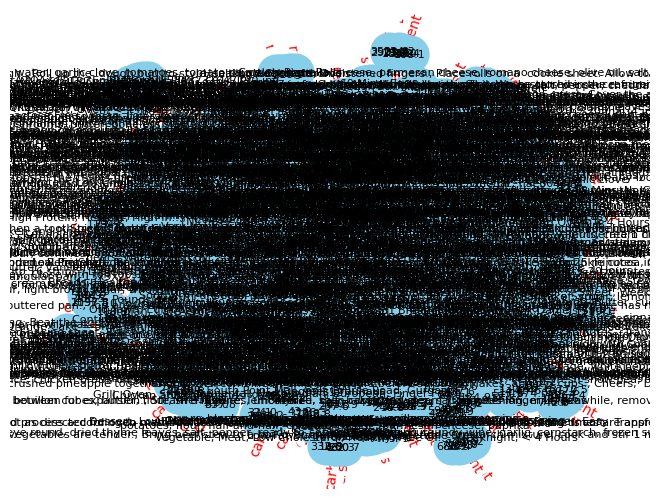

In [27]:
#@title Graph visualization

import networkx as nx
import matplotlib.pyplot as plt

def visualize_small_graph(g):

    # Convert RDF graph to NetworkX graph
    nx_graph = nx.Graph()

    for s, p, o in g:
        nx_graph.add_node(s)
        nx_graph.add_node(o)
        if p.find('#') >= 0:
            label_=str(p.split('#')[-1])
        else:
            label_=str(p.split('/')[-1])
        nx_graph.add_edge(s, o, label=label_)

    # Visualization using Matplotlib
    pos = nx.spring_layout(nx_graph)

    labels = dict({})
    for node in nx_graph.nodes():
        if node.find('#') >= 0:
            labels[node] = str(node.split('#')[-1])
        else:
            labels[node] =  str(node.split('/')[-1])

    edge_labels = {(edge[0], edge[1]): edge[2]['label'] for edge in nx_graph.edges(data=True)}

    nx.draw(nx_graph, pos, with_labels=True, labels=labels, node_size=700, node_color='skyblue', font_size=8)
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_color='red')

    # Show the plot
    plt.show()

visualize_small_graph(g)

Second visualization using html

In [31]:
from pyvis.network import Network
#@title Create a Pyvis network.
net = Network(height='750px', width='100%', directed=True)
options = '''
var options = {
  "configure": {
    "enabled": true,
    "filter": ["physics"]
  },
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -138,
      "centralGravity": 0.3,
      "springLength": 95,
      "springConstant": 0.04,
      "damping": 0.09,
      "avoidOverlap": 0.5
    },
    "minVelocity": 0.75
  }
}
'''
net.show_buttons(filter_=["physics"])
net.set_options(options)
net.from_nx(mdg)
html = net.generate_html()

output_html = "top20_graph_pyvis.html"

with open(output_html, "w") as f:
    f.write(html)